# RNN (Recurrent Neural Networks) 기초 🔄

## 📋 **Week 3 Day 1 학습 목표**

**이번 노트북에서 배울 것들:**

✅ **RNN의 핵심 개념 이해**  
✅ **순차 데이터 처리 방법**  
✅ **간단한 텍스트 생성 구현**  
✅ **LSTM의 필요성과 차이점**  
✅ **실제 문장 분류 프로젝트**

---

## 🤔 **왜 RNN이 필요할까?**

**Week 1-2에서 배운 신경망의 한계:**

### 🚫 **문제점 1: 순서 정보 무시**
```python
# 일반 신경망은 순서를 구분 못함
"좋은 영화" vs "영화 좋은" → 같은 입력으로 인식!
"I love you" vs "You love I" → 완전히 다른 의미인데...
```

### 🚫 **문제점 2: 가변 길이 처리 불가**
```python
# 입력 크기가 고정되어야 함
"안녕" (2글자) vs "안녕하세요 반갑습니다" (9글자)
# → 일반 NN으로는 처리 불가!
```

### 🚫 **문제점 3: 문맥 정보 손실**
```python
# 이전 단어들의 맥락을 기억 못함
"날씨가 좋아서 기분이 ___" 
# → "좋다"가 나와야 하는데 맥락을 모름
```

---

## ✨ **RNN이 해결하는 방법**

### 🎯 **핵심 아이디어: "기억하며 순차 처리"**

1. **순차 처리**: 단어를 하나씩 차례대로 처리
2. **기억 유지**: 이전 정보를 "숨겨진 상태"에 저장  
3. **문맥 이해**: 앞선 단어들의 의미를 누적하여 이해

---

### 📚 **이번 노트북 구성**

1. **라이브러리 & 환경 설정**
2. **RNN 핵심 개념 이해하기**
3. **간단한 RNN 직접 구현**
4. **텍스트 데이터 전처리**
5. **문장 감정 분석 프로젝트**
6. **LSTM vs RNN 비교**

**자, 이제 순차 데이터의 세계로 들어가봅시다!** 🚀


In [222]:
# 🔧 라이브러리 및 환경 설정
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

# 데이터 처리 및 시각화
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


print("=== 라이브러리 import 완료 ===")
print(f"PyTorch 버전: {torch.__version__}")

# 🎯 디바이스 설정 (GPU 가속)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"🎯 사용할 디바이스: {device}")

if device.type == "mps":
    print("   Apple Silicon GPU 가속 활성화! ⚡")
else:
    print("   CPU 사용 중")

# 🇰🇷 한글 폰트 설정 함수 (Week 2에서 가져옴)
def fix_korean_font():
    """한글 폰트 문제를 해결하는 함수"""
    try:
        import matplotlib.font_manager as fm
        import platform
        
        # 운영체제별 폰트 설정
        if platform.system() == 'Darwin':  # macOS
            font_list = ['AppleGothic', 'Apple SD Gothic Neo', 'Nanum Gothic', 'Nanum Myeongjo']
        elif platform.system() == 'Windows':
            font_list = ['Malgun Gothic', 'Nanum Gothic', 'Batang']
        else:  # Linux
            font_list = ['Nanum Gothic', 'NanumGothic', 'DejaVu Sans']
        
        # 사용 가능한 폰트 찾기
        available_fonts = [f.name for f in fm.fontManager.ttflist]
        korean_font = None
        
        for font in font_list:
            if font in available_fonts:
                korean_font = font
                break
        
        if korean_font:
            plt.rcParams['font.family'] = korean_font
            print(f"✅ 한글 폰트 설정: {korean_font}")
        else:
            plt.rcParams['font.family'] = 'DejaVu Sans'
            print("⚠️ 한글 폰트를 찾을 수 없어 기본 폰트 사용")
        
        # 공통 설정
        plt.rcParams['axes.unicode_minus'] = False
        plt.rcParams['font.size'] = 10
        
        return True
        
    except Exception as e:
        print(f"❌ 폰트 설정 실패: {e}")
        return False

# 폰트 설정 실행
fix_korean_font()
print("🎨 한글 폰트 설정 완료!")


=== 라이브러리 import 완료 ===
PyTorch 버전: 2.8.0
🎯 사용할 디바이스: mps
   Apple Silicon GPU 가속 활성화! ⚡
✅ 한글 폰트 설정: AppleGothic
🎨 한글 폰트 설정 완료!


## 🔍 **Step 1: RNN 핵심 개념 이해하기**

### 🧠 **RNN의 핵심: "기억하는 신경망"**

일반 신경망과의 차이점을 직관적으로 이해해봅시다!


In [223]:
# 🧮 RNN vs 일반 NN 비교 시각화
print("=== RNN vs 일반 NN 비교 ===")
print()

# 🔸 일반 신경망 (Feedforward)
print("🤖 일반 신경망 (Feedforward):")
print("   입력: [전체 문장] → NN → 출력")
print("   특징: 모든 단어를 동시에 처리")
print("   한계: 순서 정보 무시, 고정 길이만 가능")
print()

# 🔄 순환 신경망 (RNN)
print("🔄 순환 신경망 (RNN):")
print("   입력: [단어1] → RNN → 은닉상태1")
print("   입력: [단어2] + 은닉상태1 → RNN → 은닉상태2")
print("   입력: [단어3] + 은닉상태2 → RNN → 은닉상태3")
print("   ...")
print("   최종: 은닉상태N → 출력")
print()
print("   특징: 순차적 처리, 이전 정보 기억")
print("   장점: 순서 인식, 가변 길이 처리 가능")
print()

# 📊 실제 예시
print("📊 실제 예시:")
sentence = "날씨가 좋아서 기분이 좋다"
words = sentence.split()

print(f"   문장: '{sentence}'")
print(f"   단어들: {words}")
print()

print("🔄 RNN 처리 과정:")
hidden_state = "초기상태"
for i, word in enumerate(words):
    print(f"   단계 {i+1}: '{word}' + {hidden_state} → RNN")
    hidden_state = f"상태{i+1}"
    print(f"           → 새로운 은닉상태: {hidden_state}")
    
print(f"   최종 출력: {hidden_state} → 감정 분석 결과")
print("=" * 50)


=== RNN vs 일반 NN 비교 ===

🤖 일반 신경망 (Feedforward):
   입력: [전체 문장] → NN → 출력
   특징: 모든 단어를 동시에 처리
   한계: 순서 정보 무시, 고정 길이만 가능

🔄 순환 신경망 (RNN):
   입력: [단어1] → RNN → 은닉상태1
   입력: [단어2] + 은닉상태1 → RNN → 은닉상태2
   입력: [단어3] + 은닉상태2 → RNN → 은닉상태3
   ...
   최종: 은닉상태N → 출력

   특징: 순차적 처리, 이전 정보 기억
   장점: 순서 인식, 가변 길이 처리 가능

📊 실제 예시:
   문장: '날씨가 좋아서 기분이 좋다'
   단어들: ['날씨가', '좋아서', '기분이', '좋다']

🔄 RNN 처리 과정:
   단계 1: '날씨가' + 초기상태 → RNN
           → 새로운 은닉상태: 상태1
   단계 2: '좋아서' + 상태1 → RNN
           → 새로운 은닉상태: 상태2
   단계 3: '기분이' + 상태2 → RNN
           → 새로운 은닉상태: 상태3
   단계 4: '좋다' + 상태3 → RNN
           → 새로운 은닉상태: 상태4
   최종 출력: 상태4 → 감정 분석 결과


### 🔬 **간단한 RNN 직접 구현해보기**

복잡한 라이브러리 사용 전에 RNN의 핵심 원리를 직접 구현해봅시다!


In [224]:
# 🛠️ 초간단 RNN 구현
print("=== 초간단 RNN 직접 구현 ===")

class SimpleRNN:
    def __init__(self, input_size, hidden_size):
        """간단한 RNN 구현"""
        self.hidden_size = hidden_size
        
        # 🎲 가중치 초기화 (랜덤)
        self.W_ih = np.random.randn(hidden_size, input_size) * 0.1   # 입력 → 은닉
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.1  # 은닉 → 은닉  
        self.b_h = np.zeros((hidden_size, 1))                       # 편향
        
        print(f"✅ SimpleRNN 생성: 입력={input_size}, 은닉={hidden_size}")
    
    def forward(self, x, h_prev):
        """한 시점의 forward pass"""
        # RNN 핵심 공식: h_t = tanh(W_ih * x_t + W_hh * h_{t-1} + b_h)
        h_new = np.tanh(
            np.dot(self.W_ih, x) +      # 현재 입력의 영향
            np.dot(self.W_hh, h_prev) + # 이전 상태의 영향  
            self.b_h                    # 편향
        )
        return h_new
    
    def process_sequence(self, sequence):
        """전체 시퀀스 처리"""
        # 초기 은닉 상태 (0으로 초기화)
        h = np.zeros((self.hidden_size, 1))
        
        hidden_states = []
        
        for t, x_t in enumerate(sequence):
            h = self.forward(x_t, h)
            hidden_states.append(h.copy())
            
            print(f"   시점 {t+1}: 입력={x_t.flatten()[:3]} → 은닉상태={h.flatten()[:3]}")
        
        return hidden_states

# 🧪 테스트 해보기
print("\n🧪 SimpleRNN 테스트:")

# 간단한 시퀀스 생성 (3차원 입력, 4개 시점)
input_size = 3
hidden_size = 5
sequence_length = 4

# 테스트 시퀀스 (각 시점마다 3차원 벡터)
test_sequence = [
    np.array([[1.0], [0.5], [0.2]]),  # 시점 1
    np.array([[0.8], [0.3], [0.7]]),  # 시점 2  
    np.array([[0.2], [0.9], [0.1]]),  # 시점 3
    np.array([[0.6], [0.1], [0.8]])   # 시점 4
]

# RNN 생성 및 실행
rnn = SimpleRNN(input_size, hidden_size)
hidden_states = rnn.process_sequence(test_sequence)

print(f"\n✅ 처리 완료! 총 {len(hidden_states)}개의 은닉 상태 생성")
print(f"   최종 은닉상태 모양: {hidden_states[-1].shape}")
print("=" * 50)


=== 초간단 RNN 직접 구현 ===

🧪 SimpleRNN 테스트:
✅ SimpleRNN 생성: 입력=3, 은닉=5
   시점 1: 입력=[1.  0.5 0.2] → 은닉상태=[-0.06574149  0.01861869  0.22330076]
   시점 2: 입력=[0.8 0.3 0.7] → 은닉상태=[-0.17584518  0.05173059  0.14466258]
   시점 3: 입력=[0.2 0.9 0.1] → 은닉상태=[0.07142205 0.03565177 0.16512695]
   시점 4: 입력=[0.6 0.1 0.8] → 은닉상태=[-0.21860377  0.06212489  0.05081217]

✅ 처리 완료! 총 4개의 은닉 상태 생성
   최종 은닉상태 모양: (5, 1)


## 📝 **Step 2: 텍스트 데이터 전처리**

### 🔤 **텍스트를 숫자로 변환하기**

RNN이 텍스트를 이해하려면 단어를 숫자로 바꿔야 해요!


In [225]:
# 📚 텍스트 전처리 도구 만들기
print("=== 텍스트 전처리 도구 ===")

class TextPreprocessor:
    def __init__(self):
        self.word_to_idx = {}  # 단어 → 인덱스
        self.idx_to_word = {}  # 인덱스 → 단어
        self.vocab_size = 0
        
        # 특수 토큰들
        self.PAD_TOKEN = "<PAD>"    # 패딩 (길이 맞추기)
        self.UNK_TOKEN = "<UNK>"    # 모르는 단어
        self.START_TOKEN = "<START>" # 문장 시작
        self.END_TOKEN = "<END>"    # 문장 끝
        
    def build_vocab(self, sentences):
        """문장들로부터 어휘 사전 구축"""
        word_counts = Counter()
        
        # 모든 문장에서 단어 수집
        for sentence in sentences:
            words = self.tokenize(sentence)
            word_counts.update(words)
        
        # 특수 토큰 추가
        self.word_to_idx = {
            self.PAD_TOKEN: 0,
            self.UNK_TOKEN: 1,
            self.START_TOKEN: 2,
            self.END_TOKEN: 3
        }
        
        # 빈도 높은 단어부터 인덱스 할당
        for word, count in word_counts.most_common():
            if word not in self.word_to_idx:
                self.word_to_idx[word] = len(self.word_to_idx)
        
        # 역방향 매핑 생성
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.vocab_size = len(self.word_to_idx)
        
        print(f"✅ 어휘 사전 구축 완료:")
        print(f"   총 어휘 수: {self.vocab_size}개")
        print(f"   특수 토큰: {[self.PAD_TOKEN, self.UNK_TOKEN, self.START_TOKEN, self.END_TOKEN]}")
        print(f"   상위 10개 단어: {list(word_counts.most_common(10))}")
        
    def tokenize(self, sentence):
        """문장을 단어로 분리"""
        # 간단한 토크나이징 (공백 기준 + 구두점 분리)
        sentence = sentence.lower().strip()
        # 구두점 앞뒤에 공백 추가
        for punct in ".,!?;:":
            sentence = sentence.replace(punct, f" {punct} ")
        
        words = sentence.split()
        return [word for word in words if word.strip()]
    
    def encode_sentence(self, sentence, max_length=None, add_start_end=True):
        """문장을 인덱스 시퀀스로 변환"""
        words = self.tokenize(sentence)
        
        # START/END 토큰 추가
        if add_start_end:
            words = [self.START_TOKEN] + words + [self.END_TOKEN]
        
        # 단어 → 인덱스 변환
        indices = []
        for word in words:
            if word in self.word_to_idx:
                indices.append(self.word_to_idx[word])
            else:
                indices.append(self.word_to_idx[self.UNK_TOKEN])
        
        # 길이 조정
        if max_length:
            if len(indices) < max_length:
                # 패딩 추가
                indices.extend([self.word_to_idx[self.PAD_TOKEN]] * (max_length - len(indices)))
            else:
                # 길이 자르기
                indices = indices[:max_length]
        
        return indices
    
    def decode_indices(self, indices):
        """인덱스 시퀀스를 문장으로 변환"""
        words = []
        for idx in indices:
            if idx in self.idx_to_word:
                word = self.idx_to_word[idx]
                if word not in [self.PAD_TOKEN, self.START_TOKEN, self.END_TOKEN]:
                    words.append(word)
        return " ".join(words)

# 🧪 텍스트 전처리 테스트
print("\n🧪 텍스트 전처리 테스트:")

# 샘플 문장들
sample_sentences = [
    "오늘 날씨가 정말 좋네요!",
    "영화가 너무 재미있었어요.",
    "음식이 맛없어서 실망했습니다.",
    "서비스가 친절하고 좋았어요.",
    "가격이 비싸서 아쉬워요.",
    "다시 오고 싶은 곳이에요!",
    "별로 추천하지 않아요.",
    "완전 최고였습니다!"
]

# 전처리기 생성 및 어휘 구축
preprocessor = TextPreprocessor()
preprocessor.build_vocab(sample_sentences)

print(f"\n📝 문장 인코딩 예시:")
test_sentence = "오늘 영화가 정말 재미있었어요!"
encoded = preprocessor.encode_sentence(test_sentence, max_length=10)
decoded = preprocessor.decode_indices(encoded)

print(f"   원본: '{test_sentence}'")
print(f"   토큰화: {preprocessor.tokenize(test_sentence)}")
print(f"   인코딩: {encoded}")
print(f"   디코딩: '{decoded}'")
print("=" * 50)


=== 텍스트 전처리 도구 ===

🧪 텍스트 전처리 테스트:
✅ 어휘 사전 구축 완료:
   총 어휘 수: 31개
   특수 토큰: ['<PAD>', '<UNK>', '<START>', '<END>']
   상위 10개 단어: [('.', 5), ('!', 3), ('오늘', 1), ('날씨가', 1), ('정말', 1), ('좋네요', 1), ('영화가', 1), ('너무', 1), ('재미있었어요', 1), ('음식이', 1)]

📝 문장 인코딩 예시:
   원본: '오늘 영화가 정말 재미있었어요!'
   토큰화: ['오늘', '영화가', '정말', '재미있었어요', '!']
   인코딩: [2, 6, 10, 8, 12, 5, 3, 0, 0, 0]
   디코딩: '오늘 영화가 정말 재미있었어요 !'


## 🚀 **Step 3: PyTorch RNN 구현**

### 🔥 **진짜 RNN 모델 만들기**

이제 PyTorch를 사용해서 실전급 RNN을 구현해봅시다!


In [226]:
# 🏗️ PyTorch RNN 모델 구현
print("=== PyTorch RNN 감정 분석 모델 ===")

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, num_classes=2, num_layers=1):
        super(SentimentRNN, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # 🔤 임베딩 레이어: 단어 인덱스 → 벡터
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # 🔄 RNN 레이어
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
        
        # 🧮 분류 레이어
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
        print(f"✅ SentimentRNN 생성:")
        print(f"   어휘 크기: {vocab_size}")
        print(f"   임베딩 차원: {embedding_dim}")
        print(f"   은닉 차원: {hidden_dim}")
        print(f"   클래스 수: {num_classes}")
        print(f"   RNN 층 수: {num_layers}")
    
    def forward(self, x):
        # x: (batch_size, sequence_length)
        
        # 1️⃣ 임베딩: 인덱스 → 벡터
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        
        # 2️⃣ RNN 통과
        rnn_out, hidden = self.rnn(embedded)  # rnn_out: (batch_size, seq_len, hidden_dim)
        
        # 3️⃣ 마지막 시점의 출력 사용 (감정 분석)
        last_output = rnn_out[:, -1, :]  # (batch_size, hidden_dim)
        
        # 4️⃣ 분류
        dropped = self.dropout(last_output)
        output = self.fc(dropped)  # (batch_size, num_classes)
        
        return output

# 🧪 모델 테스트
print("\n🧪 RNN 모델 테스트:")

# 모델 생성
vocab_size = preprocessor.vocab_size
model = SentimentRNN(vocab_size, embedding_dim=50, hidden_dim=64, num_classes=2)
model.to(device)

# 테스트 입력 생성
test_sentences = [
    "영화가 정말 재미있었어요!",
    "음식이 너무 맛없어서 실망했어요."
]

print(f"\n📝 테스트 문장들:")
for i, sentence in enumerate(test_sentences):
    encoded = preprocessor.encode_sentence(sentence, max_length=15, add_start_end=False)
    print(f"   {i+1}. '{sentence}'")
    print(f"      → 인코딩: {encoded}")

# 배치 생성 및 모델 통과
batch_inputs = []
for sentence in test_sentences:
    encoded = preprocessor.encode_sentence(sentence, max_length=15, add_start_end=False)
    batch_inputs.append(encoded)

# 텐서로 변환
batch_tensor = torch.LongTensor(batch_inputs).to(device)
print(f"\n🔢 배치 텐서 모양: {batch_tensor.shape}")

# 모델 추론
model.eval()
with torch.no_grad():
    outputs = model(batch_tensor)
    probabilities = F.softmax(outputs, dim=1)

print(f"\n🎯 모델 출력:")
print(f"   Raw 출력: {outputs}")
print(f"   확률: {probabilities}")
print(f"   예측: {torch.argmax(probabilities, dim=1)}")

# 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
print(f"\n📊 모델 정보:")
print(f"   총 파라미터 수: {total_params:,}개")
print("=" * 50)


=== PyTorch RNN 감정 분석 모델 ===

🧪 RNN 모델 테스트:
✅ SentimentRNN 생성:
   어휘 크기: 31
   임베딩 차원: 50
   은닉 차원: 64
   클래스 수: 2
   RNN 층 수: 1

📝 테스트 문장들:
   1. '영화가 정말 재미있었어요!'
      → 인코딩: [10, 8, 12, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
   2. '음식이 너무 맛없어서 실망했어요.'
      → 인코딩: [13, 11, 14, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

🔢 배치 텐서 모양: torch.Size([2, 15])

🎯 모델 출력:
   Raw 출력: tensor([[0.0494, 0.0329],
        [0.0491, 0.0332]], device='mps:0')
   확률: tensor([[0.5041, 0.4959],
        [0.5040, 0.4960]], device='mps:0')
   예측: tensor([0, 0], device='mps:0')

📊 모델 정보:
   총 파라미터 수: 9,104개


## 🏋️‍♀️ **Step 4: 실제 훈련하기**

### 🔥 **지금까지는 "테스트"만 했어요. 이제 진짜 "학습"을 시켜봅시다!**

모델이 똑똑해지는 과정을 직접 보세요!


In [227]:
# 🎯 훈련 데이터 준비
print("=== 훈련 데이터 준비 ===")

# 📊 더 많은 훈련 데이터 생성
training_data = [
    # 긍정 문장들 (라벨 0)
    ("오늘 날씨가 정말 좋네요!", 0),
    ("영화가 너무 재미있었어요!", 0),
    ("서비스가 친절하고 좋았어요!", 0),
    ("다시 오고 싶은 곳이에요!", 0),
    ("완전 최고였습니다!", 0),
    ("정말 맛있어요!", 0),
    ("기분이 너무 좋아요!", 0),
    ("최고의 경험이었어요!", 0),
    ("정말 감사합니다!", 0),
    ("너무 행복해요!", 0),
    ("완벽한 하루였어요!", 0),
    ("정말 좋은 시간이었어요!", 0),
    
    # 부정 문장들 (라벨 1)  
    ("음식이 맛없어서 실망했습니다.", 1),
    ("가격이 비싸서 아쉬워요.", 1),
    ("별로 추천하지 않아요.", 1),
    ("서비스가 너무 느려요.", 1),
    ("정말 짜증나네요.", 1),
    ("최악의 경험이었어요.", 1),
    ("돈이 아까워요.", 1),
    ("다시는 안 올 것 같아요.", 1),
    ("너무 실망스러워요.", 1),
    ("정말 화가 나요.", 1),
    ("시간 낭비였어요.", 1),
    ("너무 별로예요.", 1),
]

print(f"✅ 훈련 데이터 준비 완료:")
print(f"   총 문장 수: {len(training_data)}개")
print(f"   긍정 문장: {sum(1 for _, label in training_data if label == 0)}개")
print(f"   부정 문장: {sum(1 for _, label in training_data if label == 1)}개")

# 📝 전체 문장으로 어휘 사전 재구축
all_sentences = [sentence for sentence, _ in training_data]
preprocessor.build_vocab(all_sentences)

print(f"\n📚 새로운 어휘 사전:")
print(f"   어휘 수: {preprocessor.vocab_size}개")
print("=" * 50)


=== 훈련 데이터 준비 ===
✅ 훈련 데이터 준비 완료:
   총 문장 수: 24개
   긍정 문장: 12개
   부정 문장: 12개
✅ 어휘 사전 구축 완료:
   총 어휘 수: 58개
   특수 토큰: ['<PAD>', '<UNK>', '<START>', '<END>']
   상위 10개 단어: [('!', 12), ('.', 12), ('정말', 6), ('너무', 6), ('서비스가', 2), ('경험이었어요', 2), ('오늘', 1), ('날씨가', 1), ('좋네요', 1), ('영화가', 1)]

📚 새로운 어휘 사전:
   어휘 수: 58개


In [228]:
# 🏗️ 새 모델 생성 및 훈련 설정
print("=== 훈련용 모델 생성 ===")

# 새로운 어휘 크기로 모델 재생성
vocab_size = preprocessor.vocab_size
model = SentimentRNN(vocab_size, embedding_dim=64, hidden_dim=128, num_classes=2)
model.to(device)

# 📊 훈련 설정
criterion = nn.CrossEntropyLoss()  # 분류 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 최적화기

print(f"✅ 모델 및 훈련 설정 완료:")
print(f"   손실 함수: CrossEntropyLoss")
print(f"   최적화기: Adam (lr=0.001)")
print(f"   총 파라미터: {sum(p.numel() for p in model.parameters()):,}개")

# 🎯 데이터 전처리 (훈련용)
train_inputs = []
train_labels = []

max_length = 12  # 문장 최대 길이

for sentence, label in training_data:
    # 문장 인코딩
    encoded = preprocessor.encode_sentence(sentence, max_length=max_length, add_start_end=False)
    train_inputs.append(encoded)
    train_labels.append(label)

# 텐서로 변환
train_inputs_tensor = torch.LongTensor(train_inputs).to(device)
train_labels_tensor = torch.LongTensor(train_labels).to(device)

print(f"\n📊 훈련 데이터 형태:")
print(f"   입력 텐서: {train_inputs_tensor.shape}")
print(f"   라벨 텐서: {train_labels_tensor.shape}")
print("=" * 50)


=== 훈련용 모델 생성 ===
✅ SentimentRNN 생성:
   어휘 크기: 58
   임베딩 차원: 64
   은닉 차원: 128
   클래스 수: 2
   RNN 층 수: 1
✅ 모델 및 훈련 설정 완료:
   손실 함수: CrossEntropyLoss
   최적화기: Adam (lr=0.001)
   총 파라미터: 28,802개

📊 훈련 데이터 형태:
   입력 텐서: torch.Size([24, 12])
   라벨 텐서: torch.Size([24])


In [229]:
# 🔥 실제 훈련 시작!
print("=== RNN 훈련 시작! ===")

# 훈련 진행상황 기록용
train_losses = []
train_accuracies = []

epochs = 50  # 50번 반복 학습
print_every = 10  # 10 epoch마다 출력

print(f"🎯 훈련 설정:")
print(f"   에포크 수: {epochs}")
print(f"   배치 크기: 전체 데이터 (작은 데이터셋)")
print(f"   출력 주기: {print_every} 에포크마다")
print()

# 🏋️‍♀️ 훈련 루프
model.train()  # 훈련 모드

for epoch in range(epochs):
    # Forward pass
    outputs = model(train_inputs_tensor)
    loss = criterion(outputs, train_labels_tensor)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 정확도 계산
    with torch.no_grad():
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == train_labels_tensor).sum().item()
        accuracy = correct / len(train_labels_tensor) * 100
    
    # 기록
    train_losses.append(loss.item())
    train_accuracies.append(accuracy)
    
    # 주기적 출력
    if (epoch + 1) % print_every == 0:
        print(f"🔥 Epoch [{epoch+1:2d}/{epochs}] | 손실: {loss.item():.4f} | 정확도: {accuracy:.1f}%")

print(f"\n✅ 훈련 완료!")
print(f"   최종 손실: {train_losses[-1]:.4f}")
print(f"   최종 정확도: {train_accuracies[-1]:.1f}%")
print("=" * 50)


=== RNN 훈련 시작! ===
🎯 훈련 설정:
   에포크 수: 50
   배치 크기: 전체 데이터 (작은 데이터셋)
   출력 주기: 10 에포크마다

🔥 Epoch [10/50] | 손실: 0.1178 | 정확도: 100.0%
🔥 Epoch [20/50] | 손실: 0.0028 | 정확도: 100.0%
🔥 Epoch [30/50] | 손실: 0.0008 | 정확도: 100.0%
🔥 Epoch [40/50] | 손실: 0.0004 | 정확도: 100.0%


🔥 Epoch [50/50] | 손실: 0.0003 | 정확도: 100.0%

✅ 훈련 완료!
   최종 손실: 0.0003
   최종 정확도: 100.0%


=== 훈련 과정 시각화 ===
✅ 한글 폰트 설정: AppleGothic


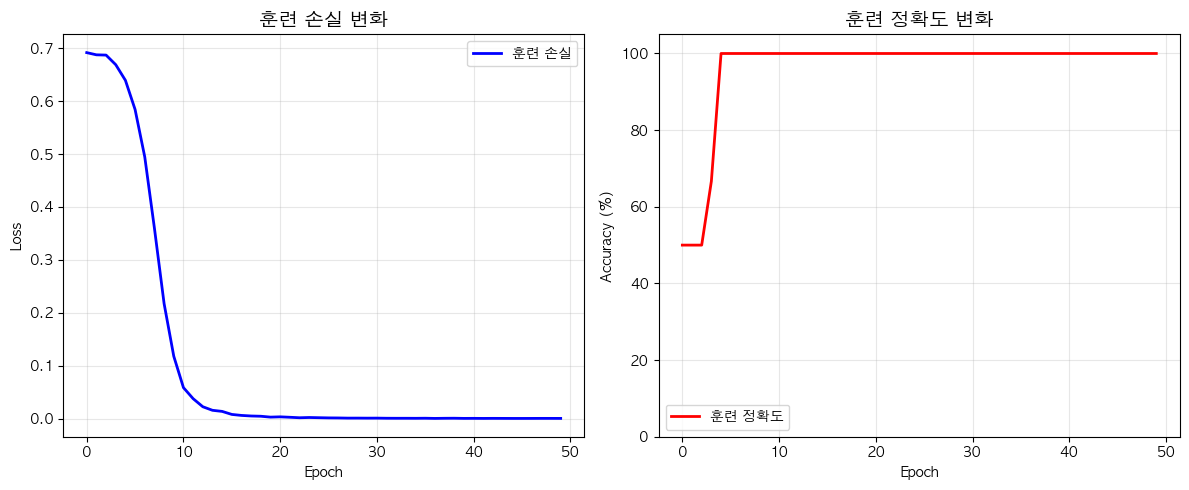

📈 훈련 결과 분석:
   시작 정확도: 50.0%
   최종 정확도: 100.0%
   정확도 향상: +50.0%
   시작 손실: 0.6918
   최종 손실: 0.0003
   손실 감소: 0.6915


In [230]:
# 📊 훈련 결과 시각화
print("=== 훈련 과정 시각화 ===")

# 한글 폰트 재설정
fix_korean_font()

# 손실과 정확도 그래프
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 손실 그래프
ax1.plot(train_losses, 'b-', linewidth=2, label='훈련 손실')
ax1.set_title('훈련 손실 변화', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 정확도 그래프  
ax2.plot(train_accuracies, 'r-', linewidth=2, label='훈련 정확도')
ax2.set_title('훈련 정확도 변화', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_ylim(0, 105)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"📈 훈련 결과 분석:")
print(f"   시작 정확도: {train_accuracies[0]:.1f}%")
print(f"   최종 정확도: {train_accuracies[-1]:.1f}%")
print(f"   정확도 향상: {train_accuracies[-1] - train_accuracies[0]:+.1f}%")
print(f"   시작 손실: {train_losses[0]:.4f}")
print(f"   최종 손실: {train_losses[-1]:.4f}")
print(f"   손실 감소: {train_losses[0] - train_losses[-1]:.4f}")
print("=" * 50)


In [231]:
# 🧪 훈련된 모델 테스트
print("=== 훈련된 모델 테스트 ===")

# 테스트 문장들
test_sentences = [
    "정말 최고의 영화였어요!",
    "너무 맛없어서 실망했어요.",
    "완벽한 서비스였습니다!",
    "돈이 아까운 선택이었어요.",
    "행복한 하루였어요!",
    "최악의 경험이었습니다."
]

# 정답 (사람이 판단)
true_labels = [0, 1, 0, 1, 0, 1]  # 0=긍정, 1=부정
label_names = ["긍정", "부정"]

print("🧪 테스트 문장별 예측 결과:")
print()

model.eval()
correct_predictions = 0

with torch.no_grad():
    for i, sentence in enumerate(test_sentences):
        # 문장 인코딩
        encoded = preprocessor.encode_sentence(sentence, max_length=max_length, add_start_end=False)
        input_tensor = torch.LongTensor([encoded]).to(device)
        
        # 예측
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        
        # 결과 출력
        true_label = true_labels[i]
        is_correct = prediction == true_label
        if is_correct:
            correct_predictions += 1
        
        print(f"📝 {i+1}. '{sentence}'")
        print(f"     예측: {label_names[prediction]} ({probabilities[0][prediction]:.1%} 확률)")
        print(f"     정답: {label_names[true_label]}")
        print(f"     결과: {'✅ 정답' if is_correct else '❌ 오답'}")
        print()

# 전체 정확도
test_accuracy = correct_predictions / len(test_sentences) * 100
print(f"🎯 테스트 결과:")
print(f"   정답 개수: {correct_predictions}/{len(test_sentences)}")
print(f"   테스트 정확도: {test_accuracy:.1f}%")

if test_accuracy >= 80:
    print("   🎉 훌륭한 성능!")
elif test_accuracy >= 60:
    print("   👍 괜찮은 성능!")
else:
    print("   💪 더 많은 훈련이 필요해요!")

print("=" * 50)


=== 훈련된 모델 테스트 ===
🧪 테스트 문장별 예측 결과:

📝 1. '정말 최고의 영화였어요!'
     예측: 긍정 (100.0% 확률)
     정답: 긍정
     결과: ✅ 정답

📝 2. '너무 맛없어서 실망했어요.'
     예측: 부정 (100.0% 확률)
     정답: 부정
     결과: ✅ 정답

📝 3. '완벽한 서비스였습니다!'
     예측: 긍정 (100.0% 확률)
     정답: 긍정
     결과: ✅ 정답

📝 4. '돈이 아까운 선택이었어요.'
     예측: 부정 (100.0% 확률)
     정답: 부정
     결과: ✅ 정답

📝 5. '행복한 하루였어요!'
     예측: 긍정 (100.0% 확률)
     정답: 긍정
     결과: ✅ 정답

📝 6. '최악의 경험이었습니다.'
     예측: 부정 (100.0% 확률)
     정답: 부정
     결과: ✅ 정답

🎯 테스트 결과:
   정답 개수: 6/6
   테스트 정확도: 100.0%
   🎉 훌륭한 성능!
